<a href="https://colab.research.google.com/github/croco22/WeldImageClassification/blob/main/LLM_model_Task2_1_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weld Image Classification - Gradio Application & LLM Prompting

This notebook provides an interactive workflow for evaluating welding joint images using a Large Language Model (LLM). The project consists of two main components:

1. Prompt Engineering for Weld Classification: A tailored prompt is developed to enable an LLM to classify weld images as good or bad. The focus is on designing precise instructions that reliably guide the LLM's reasoning when analyzing visual input.

2. Evaluation of the LLM's Performance: The LLM's weld-quality assessment is evaluated and contrasted with conventional evaluation methods from Task 1. This includes discussing differences in reasoning, reliability, and output behavior between the two approaches.

In addition to the analytical workflow, this notebook includes a Gradio-based web application that allows users to upload weld images and obtain model-generated assessments in a user-friendly interface.

**Note**: A valid `GOOGLE_API_KEY` must be configured in your Colab environment to enable the LLM image analysis.

## Imports and Setup

In [1]:
%%capture
!pip install gradio

import os
from PIL import Image
import gradio as gr
from gradio.components import InputHTMLAttributes
import pandas as pd
import requests
from google.colab import userdata
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import google.generativeai as genai
import kagglehub

In [2]:
# API Setup
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
DEFAULT_MODEL = 'gemini-2.5-flash'

# Download dataset
kagglehub.dataset_download("sukmaadhiwijaya/welding-defect-object-detection")

# Download favicon
image_url = "https://raw.githubusercontent.com/croco22/CapstoneProjectTDS/refs/heads/main/images/croco.jpg"
img_data = requests.get(image_url).content
with open('favicon.png', 'wb') as handler:
    handler.write(img_data)

## Prompt Engineering for Weld Classification

In [3]:
WELD_PROMPT = """Analyze the provided image of a welding joint according to professional welding
quality criteria and ISO standards, especially ISO 5817 for acceptable weld imperfections.
Evaluate the weld based on surface uniformity, penetration consistency, porosity, cracks,
undercut, excessive spatter, fusion defects, and geometrical correctness.

Consider whether the weld displays visible defects such as porosity holes, incomplete fusion,
underfill, burn-through, irregular bead shape, or excessive reinforcement. Assess whether the
joint meets typical requirements for a structurally sound weld in industrial practice.

Your task is to classify the weld strictly as either good (1) or bad (0).

After the classification, provide a short explanation:
- If the weld is good (1), describe the positive aspects that indicate good weld quality.
- If the weld is bad (0), describe the specific defects or issues visible in the weld.

Return ONLY the following format:
<0-or-1>;<short-description>

The short description must be a concise text with no line breaks.
Output ONLY these two space-separated elements."""

## Evaluation of the LLM's Performance

In [4]:
def analyze_weld_image(image_input, prompt_input=WELD_PROMPT, selected_model=DEFAULT_MODEL):
    model = genai.GenerativeModel(selected_model)
    response = model.generate_content([prompt_input, image_input])
    response_parts = response.text.strip().split(';')
    try:
        first_digit = int(response_parts[0])
    except ValueError:
        first_digit = -1
    description = response_parts[1] if len(response_parts) > 1 else None
    return first_digit, description

In [5]:
label_dir = "/kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/train/labels"
image_dir = "/kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/train/images"

rows = []
LIMIT = 100

for fname in os.listdir(label_dir)[:LIMIT]:
    if fname.endswith(".txt"):
        label_path = os.path.join(label_dir, fname)
        image_name = fname.replace(".txt", ".jpg")
        image_path = os.path.join(image_dir, image_name)

        if not os.path.exists(image_path):
            continue

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            continue

        with open(label_path, "r") as f:
            content = f.read().strip()

        if content:
            first_char = content[0]
            try:
                first_digit = int(first_char)
            except ValueError:
                first_digit = -1
        else:
            first_digit = -1

        if first_digit == 2:
            first_digit = 0

        predicted = None
        try:
            predicted, description = analyze_weld_image(image)
        except Exception as e:
            predicted = -1
            description = None

        rows.append({
            "filename": fname,
            "actual": first_digit,
            "predicted": predicted,
            "description": description
        })

df = pd.DataFrame(rows)
df.head()

,filename,actual,predicted,description
0,istockphoto-1006281450-612x612_jpeg.rf.cd5a96f...,0,0,"The weld exhibits severe lack of uniformity, i..."
1,good_weld_vid1939_jpeg.rf.4b6df404008d30bb14de...,1,1,"Excellent bead uniformity, consistent ripple p..."
2,good_weld_vid1606_jpeg_jpg.rf.0380bddd8aacabeb...,1,1,The weld displays excellent surface uniformity...
3,SampleV2_2_mp4-45_jpg.rf.f2a431b74fa4963191b4d...,0,1,The weld exhibits a consistent bead profile wi...
4,Screenshot-2022-12-05-230019_jpeg.rf.c21508447...,1,0,"Excessive and irregular reinforcement, poor be..."


### Evaluation Results

In [6]:
df_clean = df[(df["actual"] != -1) & (df["predicted"] != -1)]

y_true = df_clean["actual"]
y_pred = df_clean["predicted"]

results = {
    "accuracy": accuracy_score(y_true, y_pred),
    "precision": precision_score(y_true, y_pred, zero_division=0),
    "recall": recall_score(y_true, y_pred, zero_division=0),
    "f1_score": f1_score(y_true, y_pred, zero_division=0)
}

print(results)

{'accuracy': 0.68, 'precision': 0.9565217391304348, 'recall': 0.41509433962264153, 'f1_score': 0.5789473684210527}


<Figure size 500x500 with 0 Axes>

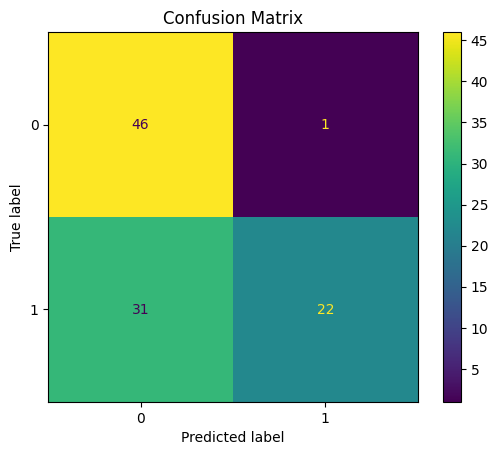

In [7]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(5, 5))
disp.plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

## Gradio Application

In [8]:
custom_css = """
.gradio-container {
    padding-left: 15% !important;
    padding-right: 15% !important;
}
"""

In [9]:
def analyzer_handler(image_input, selected_model_name, prompt_input):
    prediction, description = analyze_weld_image(image_input, prompt_input, selected_model_name)
    answer = f"""### That is a {'good' if prediction==1 else 'bad'} weld!<br>Reason: {description}"""
    return (
        gr.update(visible=False),     # dont show dropdown
        gr.update(visible=False),     # dont show prompt
        gr.update(visible=False),     # dont show analyze button
        gr.update(value=answer),      # show answer text
        gr.update(visible=True)       # show new analysis button
    )

def reset_state():
    return (
        gr.update(value=None),        # remove image from cache
        gr.update(visible=True),      # show dropdown
        gr.update(visible=True),      # show prompt
        gr.update(visible=True),      # show analyze button
        gr.update(value=""),          # remove answer from cache
        gr.update(visible=False)      # dont show new analysis button
    )

In [ ]:
with gr.Blocks(theme='Nymbo/Nymbo_Theme', css=custom_css, title='Weld Image Analysis') as weld_app:
    gr.Markdown("""
        # Weld Image Analysis
        ## by Group 3
        <br>
    """)

    # List of available Gemini models for the dropdown
    # https://ai.google.dev/gemini-api/docs/models
    gemini_models = [
        'gemini-pro-latest',
        'gemini-flash-latest',
        'gemini-flash-lite-latest'
    ]

    image_input = gr.Image(type='pil', label="Upload Weld Image")

    model_selector = gr.Dropdown(
        choices=gemini_models,
        label="Select Gemini Model",
        value=gemini_models[1]
    )

    prompt_input = gr.Textbox(
        label="Adjust Prompt",
        value=WELD_PROMPT,
        html_attributes=InputHTMLAttributes(spellcheck=False)
    )

    analyze_button = gr.Button("Analyze Weld")
    output_text = gr.Markdown("")
    new_button = gr.Button("Start New Analysis", visible=False)


    # Call analyze_weld_image() function
    analyze_button.click(
        fn=analyzer_handler,
        inputs=[image_input, model_selector, prompt_input],
        outputs=[model_selector, prompt_input, analyze_button, output_text, new_button]
    )

    # Call reset_state() function
    new_button.click(
        reset_state,
        outputs=[image_input, model_selector, prompt_input, analyze_button, output_text, new_button]
    )

weld_app.launch(share=True, inline=False, favicon_path='/content/favicon.png', debug=True)

/tmp/ipython-input-2212305284.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme='Nymbo/Nymbo_Theme', css=custom_css, title='Weld Image Analysis') as weld_app:
/tmp/ipython-input-2212305284.py:1: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(theme='Nymbo/Nymbo_Theme', css=custom_css, title='Weld Image Analysis') as weld_app:


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ca89f78fc711be735b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
